## Birthday Paradox

In a group of 5 people, how likely is it that everyone has a unique birthday (assuming that nobody was born on February 29th of a leap year)? You may feel it is highly likely because there are $365$ days in a year and loosely speaking, $365$ is "much greater" than $5$. Indeed, as you shall see, this probability is greater than $0.9$. However, in a group of $25$ or more, what is the probability that no two persons have the same birthday? You might be surprised to know that the answer is less than a half. This is known as the "birthday paradox".

In general, for a group of $n$ people, the probability that <font color='red'>no two persons share the same birthday</font> can be calculated as:

\begin{align*}
P &= \frac{\text{Number of } n \text{-permutations of birthdays}}{\text{Total number of birthday assignments allowing repeated birthdays}}\\
&= \frac{365!/(365-n)!}{365^n}\\
&= \prod_{k=1}^n \frac{365-k+1}{365}
\end{align*}

Observe that this value decreases with $n$. At $n=23$, this value goes below half. The following cell simulates this event and compares the associated empirical and theoretical probabilities. You can use the slider called "iterations" to vary the number of iterations performed by the code.

In [2]:
import itertools
import random

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# Range of number of people
PEOPLE = np.arange(1, 26)
print('type(PEOPLE)',type(PEOPLE))
print(PEOPLE)

# Days in year
DAYS = 365


def prob_unique_birthdays(num_people):
    '''
    Returns the probability that all birthdays are unique, among a given
    number of people with uniformly-distributed birthdays.
    '''
    return (np.arange(DAYS, DAYS - num_people, -1) / DAYS).prod() #上面顯示的公式 prod:numpy array的所有元素相乘


def sample_unique_birthdays(num_people):
    '''
    Selects a sample of people with uniformly-distributed birthdays, and
    returns True if all birthdays are unique (or False otherwise).
    隨機產生num_people個生日，判斷是否所有生日皆為不同天
    '''
    bdays = np.random.randint(0, DAYS, size=num_people)
    unique_bdays = np.unique(bdays)
    return len(bdays) == len(unique_bdays) 


def plot_probs(iterations):
    '''
    Plots a comparison of the probability of a group of people all having
    unique birthdays, between the theoretical and empirical probabilities.
    '''
    sample_prob = []  # Empirical prob. of unique-birthday sample 
    prob = []         # Theoretical prob. of unique-birthday sample
    
    # Compute data points to plot
    np.random.seed(1)
    for num_people in PEOPLE:
        unique_count = sum(sample_unique_birthdays(num_people) #所有人都是獨立的次數
                          for i in range(iterations))
        sample_prob.append(unique_count / iterations) #在該人數下 實際測試每個人生日為獨立的機率
        prob.append(prob_unique_birthdays(num_people)) #在該人數下 每個人生日為獨立的理論機率
    
    # Plot results
    plt.plot(PEOPLE, prob, 'k-', linewidth = 3.0, label='Theoretical probability')
    plt.plot(PEOPLE, sample_prob, 'bo-', linewidth = 3.0, label='Empirical probability')
    plt.gcf().set_size_inches(20, 10) #gcf():get current figure
    plt.axhline(0.5, color='red', linewidth = 4.0, label='0.5 threshold')
    plt.xlabel('Number of people', fontsize = 18)
    plt.ylabel('Probability of unique birthdays', fontsize = 18)
    plt.grid()
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.legend(fontsize = 18)
    plt.show()

    
interact(plot_probs,
         iterations=widgets.IntSlider(min=50, value = 500, max=5050, step=200),
         continuous_update=False, layout='bottom');

type(PEOPLE) <class 'numpy.ndarray'>
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]


interactive(children=(IntSlider(value=500, description='iterations', max=5050, min=50, step=200), Output()), _…

## Conditional Probability 

Oftentimes it is advantageous to infer the probability of certain events conditioned on other events. Say you want to estimate the probability that it will rain on a particular day. There are copious number of factors that affect rain on a particular day, but [certain clouds are good indicators of rains](https://www.nationalgeographic.com/science/earth/earths-atmosphere/clouds/). Then the question is how likely are clouds a precursor to rains? These types of problems are called [statistical classification](https://en.wikipedia.org/wiki/Statistical_classification), and concepts such as conditional probability and Bayes rule play an important role in its solution.

Dice, coins and cards are useful examples which we can use to understand the fundamental concepts of probability. There are even more interesting real world examples where we can apply these principles to. Let us analyze the [student alcohol consumption](https://www.kaggle.com/uciml/student-alcohol-consumption) dataset and see if we can infer any information regarding a student's performance relative to the time they spend studying. 

<span style="color:red">NOTE:</span> Before continuing, please download the dataset and add it to the folder where this notebook resides. If necessary, you can also review our Pandas notebook.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

The dataset consists of two parts, `student-por.csv` and `student-mat.csv`, represents the students' performance in Portuguese and Math courses, respectively. We will consider the scores in the Portuguese courses, and leave the math courses optionally to you. 

In [5]:
data_por = pd.read_csv("student-por.csv")
data_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Of the dataset's [various attributes](https://www.kaggle.com/uciml/student-alcohol-consumption/home), we will use the following two
- `G3` - final grade related with the course subject, Math or Portuguese (numeric: from 0 to 20, output target)  
- `studytime` - weekly study time (numeric: 1 : < 2 hours, 2 : 2 to 5 hours, 3 : 5 to 10 hours, or 4 : > 10 hours)  

In [10]:
attributes = ["G3","studytime"]
data_por = data_por[attributes]
data_por.head()

,G3,studytime
0,11,2
1,11,2
2,12,2
3,14,3
4,13,2


We are interested in the relationship between study-time and grade performance, but to start, let us view each attribute individually. 

The probability that a student's study-time falls in an interval can be approximated by

$${P(\text{study interval}) = \frac{\text{Number of students with this study interval}}{Total\ number\ of\ students}}$$

This is an emperical estimate, and in later lectures we will reason why this is a valid assumption.

data_temp=
 2    305
1    212
3     97
4     35
Name: studytime, dtype: int64
2    0.469954
1    0.326656
3    0.149461
4    0.053929
Name: studytime, dtype: float64
   studytime
1   0.326656
2   0.469954
3   0.149461
4   0.053929
Study Interval  Probability
< 2 hours          0.326656
2 to 5 hours       0.469954
5 to 10 hours      0.149461
> 10 hours         0.053929


Text(0.5, 0, 'Study Interval')

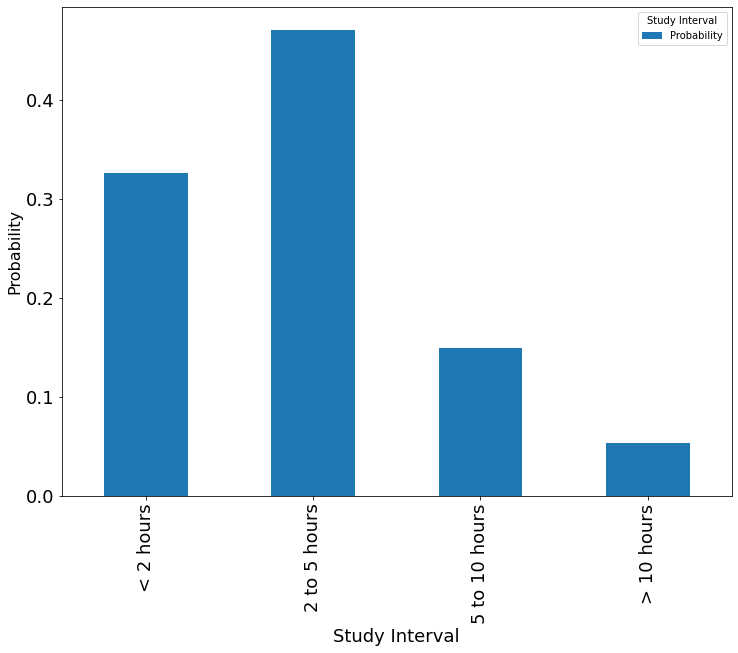

In [16]:
# 顯示學習時間的PDF
data_temp = data_por["studytime"].value_counts()
# print('data_temp=\n',data_temp)
# print(data_temp/data_temp.sum())
P_studytime = pd.DataFrame((data_temp/data_temp.sum()).sort_index()) 
# print(P_studytime)
P_studytime.index = ["< 2 hours","2 to 5 hours","5 to 10 hours","> 10 hours"]
P_studytime.columns = ["Probability"]
P_studytime.columns.name = "Study Interval"
# print(P_studytime)

P_studytime.plot.bar(figsize=(12,9),fontsize=18)
plt.ylabel("Probability",fontsize=16)
plt.xlabel("Study Interval",fontsize=18)

Note that the largest number of students studied between two and five hours, and the smallest studied over 10 hours. 

Let us call scores of at least 15 "high". The probability of a student getting a high score can be approximated by

$$P(\text{high score}) = \frac{\text{Number of students with high scores}}{\text{Total number of students}}$$

False    518
True     131
Name: G3, dtype: int64
Score  Probability
Low       0.798151
High      0.201849


Text(0, 0.5, 'Probability')

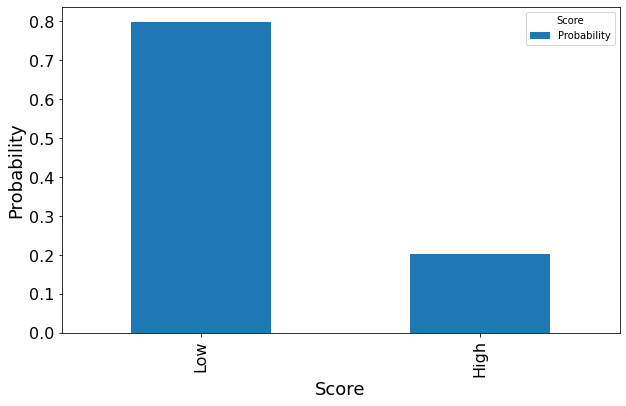

In [17]:
data_temp = (data_por["G3"]>=15).value_counts()
# print(data_temp)
P_score15_p = pd.DataFrame(data_temp/data_temp.sum())
P_score15_p.index = ["Low","High"]
P_score15_p.columns = ["Probability"]
P_score15_p.columns.name = "Score"
print(P_score15_p)
P_score15_p.plot.bar(figsize=(10,6),fontsize=16)
plt.xlabel("Score",fontsize=18)
plt.ylabel("Probability",fontsize=18)

Proceeding to more interesting observations, suppose we want to find the probability of the various study-intervals when the student scored high. By conditional probability, this can be calculated by:

$$P(\text{study interval}\ |\ \text{highscore})=\frac{\text{Number of students with study interval AND highscore}}{\text{Total number of students with highscore}}$$

Probability of study interval given that the student gets a highscore:


Text(0,0.5,'Probability')

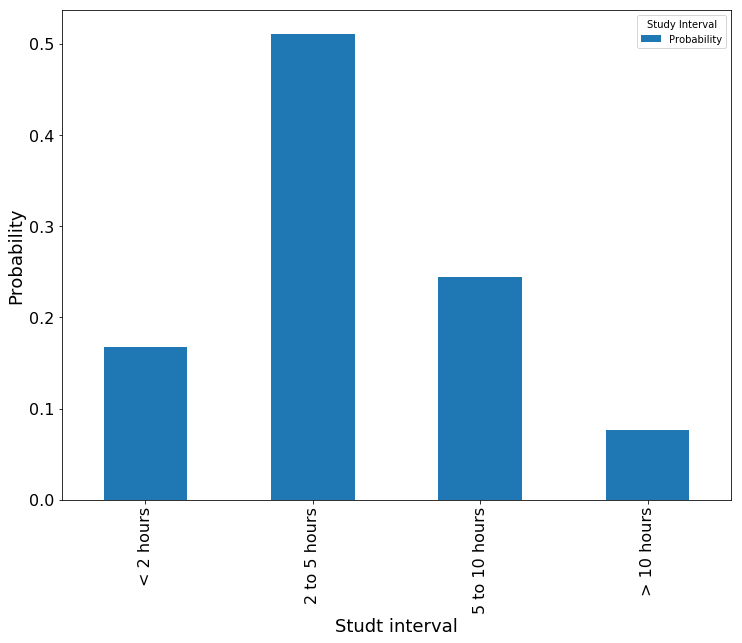

In [26]:
score = 15
data_temp = data_por.loc[data_por["G3"]>=score,"studytime"]
P_T_given_score15= pd.DataFrame((data_temp.value_counts()/data_temp.shape[0]).sort_index())
P_T_given_score15.index = ["< 2 hours","2 to 5 hours","5 to 10 hours","> 10 hours"]
P_T_given_score15.columns = ["Probability"]
print("Probability of study interval given that the student gets a highscore:")
P_T_given_score15.columns.name="Study Interval"
P_T_given_score15.plot.bar(figsize=(12,9),fontsize=16)
plt.xlabel("Studt interval",fontsize=18)
plt.ylabel("Probability",fontsize=18)

The above metric is something we can only calculate after the students have obtained their results. But how about the other way? What if we want to **predict** the probability that a student gets a score greater than 15 given that they studied for a particular period of time . Using the estimated values we can use the **Bayes rule** to calculate this probability.

$$P(\text{student getting a highscore}\ |\  \text{study interval})=\frac{P(\text{study interval}\ |\ \text{the student scored high})P(\text{highscore})}{P(\text{study interval})}$$

Probability of high score given study interval :


Text(0,0.5,'Probability')

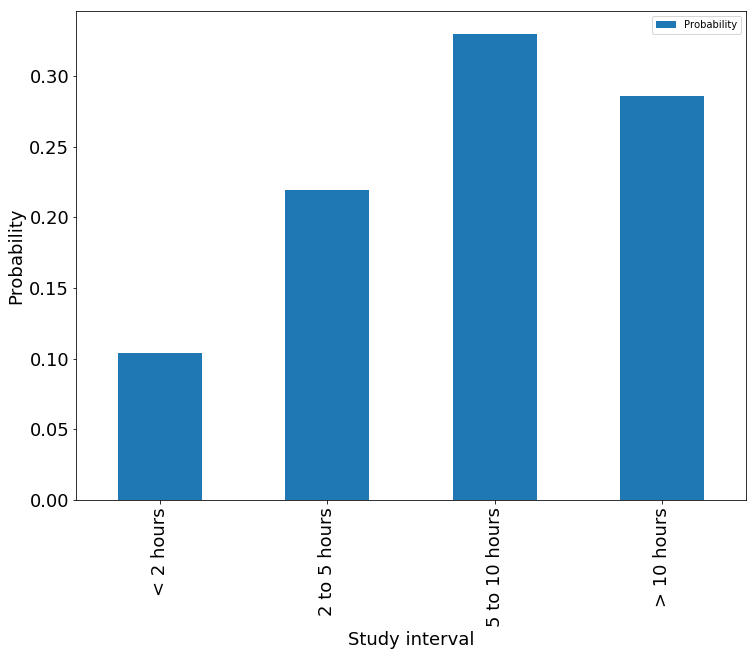

In [27]:
P_score15_given_T_p = P_T_given_score15 * P_score15_p.loc["High"] / P_studytime
print("Probability of high score given study interval :")
pd.DataFrame(P_score15_given_T_p).plot.bar(figsize=(12,9),fontsize=18).legend(loc="best")
plt.xlabel("Study interval",fontsize=18)
plt.ylabel("Probability",fontsize=18)

Do you find the results surprising? Roughly speaking, the longer students study, the more likely they are to score high. However, once they study over 10 hours, their chances of scoring high decline. You may want to check whether the same phenomenon occurs for the math scores too. 

## Try it yourself 

If interested, you can try the same analysis for the students math scores. For example, you can get the probabilities of the different study intervals. 

In [2]:
import itertools
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data_math = pd.read_csv("student-mat.csv")
data_math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Text(0, 0.5, 'Probability')

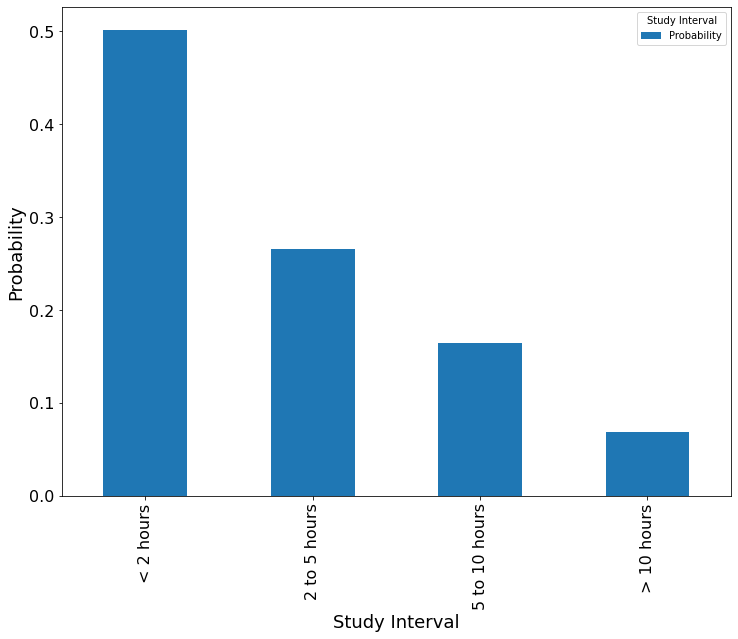

In [3]:
#P_studytime_m: P(studytime)
data_temp = data_math["studytime"].value_counts()
P_studytime_m = pd.DataFrame(data_temp/data_temp.sum())
P_studytime_m.index = ["< 2 hours","2 to 5 hours","5 to 10 hours","> 10 hours"]
P_studytime_m.columns = ["Probability"]
P_studytime_m.columns.name = "Study Interval"
P_studytime_m.plot.bar(figsize=(12,9),fontsize=16)
plt.xlabel("Study Interval",fontsize=18)
plt.ylabel("Probability",fontsize=18)

Score  Probability
False     0.898734
True      0.101266


Text(0, 0.5, 'Probability')

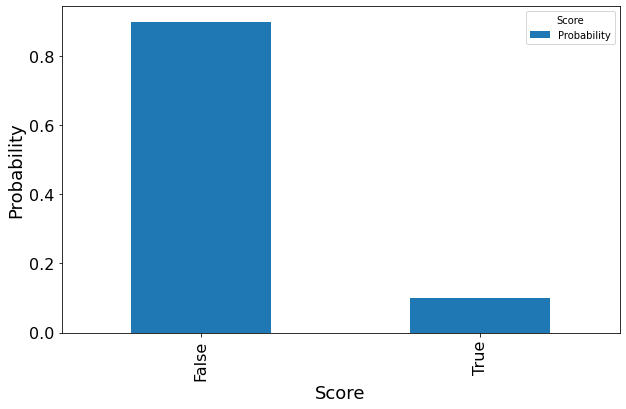

In [4]:
#P_highscore_m: P(highscore)
score = 15
data_temp = data_math[["G3","studytime"]]
# data_temp = data_temp[data_temp["G3"]>score]
P_highscore_m = pd.DataFrame((data_temp['G3']>score).value_counts()/len(data_temp))
# P_highscore_m
P_highscore_m.columns = ["Probability"]
P_highscore_m.columns.name = "Score"
print(P_highscore_m)
P_highscore_m.plot.bar(figsize=(10,6),fontsize=16)
plt.xlabel("Score",fontsize=18)
plt.ylabel("Probability",fontsize=18)


data_math.shape[0]= 395
data_temp=
 3      3
5      2
8      2
9      2
14     3
      ..
363    2
374    3
376    3
378    2
391    1
Name: studytime, Length: 73, dtype: int64
data_temp.value_count()=
 2    31
1    18
3    17
4     7
Name: studytime, dtype: int64
Probability of study interval given that the student gets a highscore:


Text(0, 0.5, 'Probability')

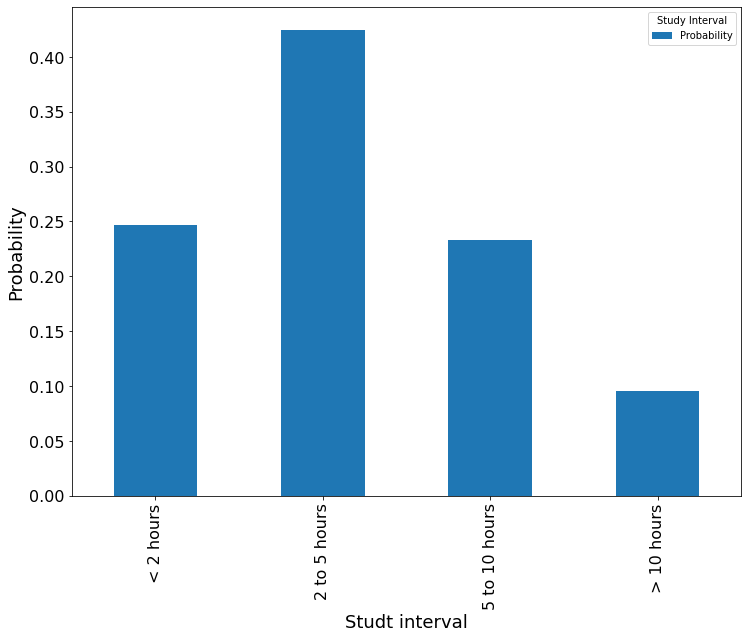

In [11]:
#P_T_given_score15: P(studytime|highscore)
score = 15
data_temp = data_math.loc[data_math["G3"]>=score,"studytime"]
print('data_math.shape[0]=',data_math.shape[0])
print('data_temp=\n',data_temp)
print('data_temp.value_count()=\n',data_temp.value_counts())
P_T_given_score15= pd.DataFrame((data_temp.value_counts()/data_temp.shape[0]).sort_index()) #data_temp.shape[0]:所有highscore的人數
P_T_given_score15.index = ["< 2 hours","2 to 5 hours","5 to 10 hours","> 10 hours"]
P_T_given_score15.columns = ["Probability"]
print("Probability of study interval given that the student gets a highscore:")
P_T_given_score15.columns.name="Study Interval"
P_T_given_score15.plot.bar(figsize=(12,9),fontsize=16)
plt.xlabel("Studt interval",fontsize=18)
plt.ylabel("Probability",fontsize=18)

Probability of high score given study interval :


Text(0, 0.5, 'Probability')

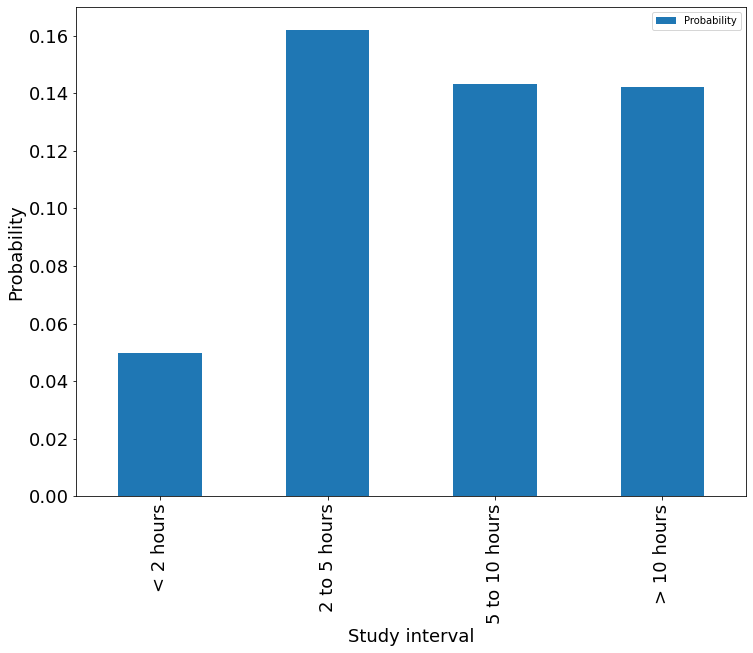

In [24]:
#P_highscore_given_studytime
P_h_given_studytime = P_T_given_score15*P_highscore_m.loc[True]/P_studytime_m
# P_h_given_studytime
print("Probability of high score given study interval :")
pd.DataFrame(P_h_given_studytime).plot.bar(figsize=(12,9),fontsize=18).legend(loc="best")
plt.xlabel("Study interval",fontsize=18)
plt.ylabel("Probability",fontsize=18)